In [2]:
# 定义一个句子列表，后面会用这些句子来训练CBOW和CBOW模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成词汇
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词汇映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词汇
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print("词汇表：", word_list) # 输出词汇表
print("词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print("索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print("词汇表大小：", voc_size)         # 输出词汇表大小

词汇表： ['Kage', 'Niuzong', 'Student', 'Xiaobing', 'Boss', 'Mazong', 'is', 'Xiaoxue', 'Teacher']
词汇到索引的字典： {'Kage': 0, 'Niuzong': 1, 'Student': 2, 'Xiaobing': 3, 'Boss': 4, 'Mazong': 5, 'is': 6, 'Xiaoxue': 7, 'Teacher': 8}
索引到词汇的字典： {0: 'Kage', 1: 'Niuzong', 2: 'Student', 3: 'Xiaobing', 4: 'Boss', 5: 'Mazong', 6: 'is', 7: 'Xiaoxue', 8: 'Teacher'}
词汇表大小： 9


In [3]:
# 生成CBOW训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()                     # 将句子分割成单词列表
        for idx, word in enumerate(sentence):           # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各window_size个单词作为上下文词汇
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data

# 使用函数创建CBOW训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的CBOW数据样例（前三个）
print("CBOW数据样例（未编码）：", cbow_data[:3])

CBOW数据样例（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [4]:
# 定义One-Hot编码函数
import torch # 导入torch库
def one_hot_encoding(word, word_to_idx):
    # 创建一个全为0的张量，长度与词汇表大小相同
    tensor = torch.zeros(len(word_to_idx))  
    tensor[word_to_idx[word]] = 1  # 将对应词汇的索引位置置为1
    return tensor  # 返回生成的One-Hot向量

# 展示One-Hot编码前后的数据
word_example = "Teacher"
print("One-Hot编码前的单词：", word_example)
print("One-Hot编码后的向量：", one_hot_encoding(word_example, word_to_idx))

# 展示编码后的CBOW数据样例
# 展示编码后的CBOW数据样例
print("CBOW数据样例（已编码）：", [(one_hot_encoding(target, word_to_idx), 
                          [one_hot_encoding(context, word_to_idx) for context in context_words]) 
                         for target, context_words in cbow_data[:3]])

One-Hot编码前的单词： Teacher
One-Hot编码后的向量： tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])
CBOW数据样例（已编码）： [(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), [tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])]), (tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]), [tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])]), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), [tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.])])]


In [5]:
# 定义CBOW模型
import torch.nn as nn # 导入neural network# 定义CBOW模型
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, 
                                         embedding_size, bias=False)  
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, 
                                          voc_size, bias=False)  

    def forward(self, X): # X: [num_context_words, voc_size]
        
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)  
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        hidden_layer = torch.mean(embeddings, dim=0)  
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0)) 
        return output_layer
    
embedding_size = 2 # 设定嵌入层的大小，这里选择2是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化cbow模型
print("CBOW模型：", cbow_model)

CBOW模型： CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.19175074895223
Epoch: 200, Loss: 2.1833301544189454
Epoch: 300, Loss: 2.1748303890228273
Epoch: 400, Loss: 2.1657649517059325
Epoch: 500, Loss: 2.155634371439616
Epoch: 600, Loss: 2.143884046872457
Epoch: 700, Loss: 2.129864700635274
Epoch: 800, Loss: 2.1127904494603476
Epoch: 900, Loss: 2.0916985114415487
Epoch: 1000, Loss: 2.0654141505559287


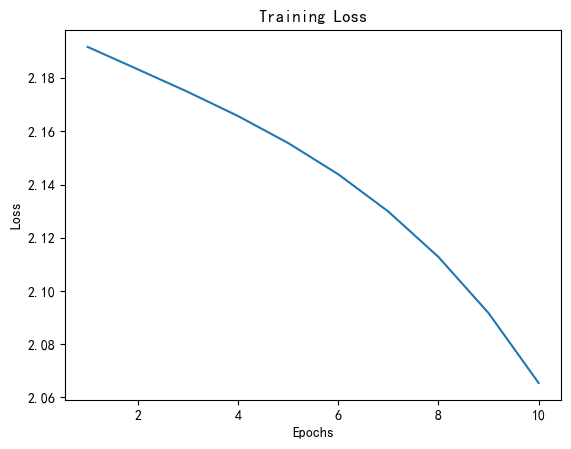

In [6]:
# 训练CBOW模型
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)  

# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0
    for target, context_words in cbow_data:
        # 将上下文词转换为One-hot向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float() 
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)  # 将目标词转换为索引值
        y_pred = cbow_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item()
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
    if (epoch+1) % 100 == 0: # 输出每100轮的损失，并记录损失
        print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")  
        loss_values.append(loss_sum / len(cbow_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入matplotlib
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title('Training Loss') # 图题
plt.xlabel('Epochs') # X轴Label
plt.ylabel('Loss') # Y轴Label
plt.show() # 显示图

In [7]:
# 输出CBOW习得的词嵌入
print("\nCBOW词嵌入:")
for word, idx in word_to_idx.items(): # 输出每个单词的嵌入向量
    print(f"{word}: {cbow_model.input_to_hidden.weight[:, idx].detach().numpy()}")  


CBOW词嵌入:
Kage: [ 0.51901424 -0.01590744]
Niuzong: [-0.16080283 -0.275055  ]
Student: [0.08546517 0.5262374 ]
Xiaobing: [-0.37308294  0.11700206]
Boss: [0.06071663 0.5952715 ]
Mazong: [ 0.24235012 -0.01861949]
is: [-0.40392137 -0.35928565]
Xiaoxue: [-0.3661933   0.12211579]
Teacher: [0.37023693 0.328033  ]


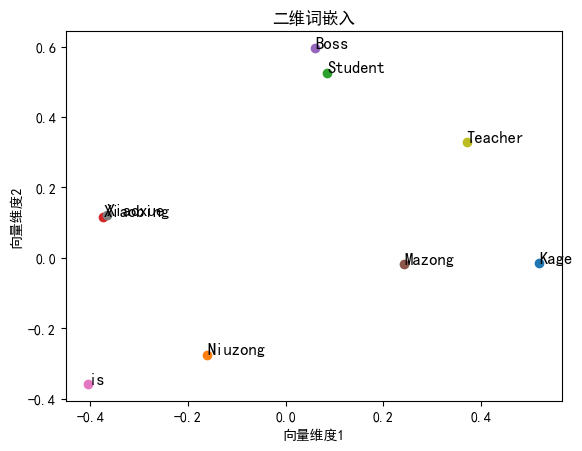

In [8]:
import matplotlib.pyplot as plt # 导入matplotlib
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
# 绘制二维词向量图
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    vec = cbow_model.input_to_hidden.weight[:, \
            idx].detach().numpy() # 获取每个单词的嵌入向量
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title('二维词嵌入') # 图题
plt.xlabel('向量维度1') # X轴Label
plt.ylabel('向量维度2') # Y轴Label
plt.show() # 显示图